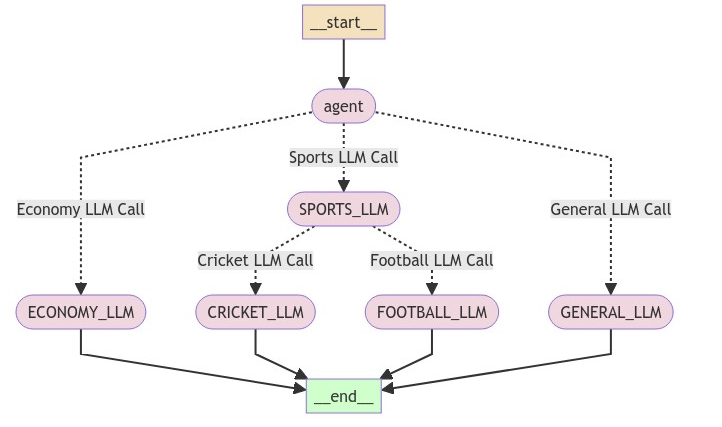


In [1]:
import os
from crewai import Agent, Task, Crew, Process
from langchain.tools import DuckDuckGoSearchRun
from langchain_openai import AzureChatOpenAI
search_tool = DuckDuckGoSearchRun()
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_community.llms import Ollama

llm = Ollama(
    model="mistral"
)  # assuming you have Ollama installed and have llama3 model pulled with `ollama pull llama3 `


In [3]:
llm = AzureChatOpenAI(temperature = 0, model = "gpt-35-turbo-16k")

In [4]:
llm.invoke('Hi')

AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17}, 'model_name': 'gpt-35-turbo-16k', 'system_fingerprint': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='run-d9cc53f0-70d4-476b-8468-ea67592c658c-0')

In [5]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

### Making Complex Graphs with Conditional Edges

In [6]:
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate


class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    #Reasoning: str = Field(description='Reasoning behind topic selection')

parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

## Topic Selector

In [7]:
def function_1(state):
    print('-> Calling Agent ->')
    messages = state['messages']
    question = messages[-1]   # Fetching the user question
    
    template = """ Your task is to provide only the topic based on the user query. 
        Only output the topic among: [Economy,Sports,General]. Don't include reasoning. 
        Following is the user query:  {question}
        {format_instructions} """
    
    prompt = PromptTemplate(template=template,
                            input_variables=['question'],
                            partial_variables={"format_instructions": parser.get_format_instructions()}
                           )
    chain = prompt | llm | parser

    response = chain.invoke({"question": question, "format_instructions": parser.get_format_instructions()})
    print(response)

    return {"messages": [response.Topic]}

In [10]:
def router(state):
    print('-> Router ->')
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'Economy' in last_message:
        return 'Economy LLM Call'
    elif 'Sports' in last_message:
        return 'Sports LLM Call'
    else:
        return 'General LLM Call'

def sports_supervisor(state):
    print('-> Sports Router ->')
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'cricket' in last_message.lower():
        return 'Cricket LLM Call'
    else:
        return 'Football LLM Call'

def function_2(state):
    print('-> Calling Economy LLM ->')
    messages = state['messages']
    question = messages[0]  # Fetching the user question

    # Normal LLM call
    complete_query = "You are an Expert in Finance & Economy. Answer the following question with your economic knowledge. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

def function_4(state):
    print('-> Calling General LLM ->')
    messages = state['messages']
    question = messages[0]  # Fetching the user question

    # Normal LLM call
    complete_query = "Answer the following question with your knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

def general_sports(state):
    print('-> Calling Sports LLM ->')
    messages = state['messages']
    question = messages[0]  # Fetching the user question

    # Normal LLM call
    complete_query = "You are an Expert in Sports knowledge. You need to classify the sports question only into these two categories [cricket, football]. Return only the classified topic. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

def sports_cricket(state):
    print('-> Calling Sports LLM (Cricket) ->')
    messages = state['messages']
    question = messages[0]  # Fetching the user question

    # Normal LLM call
    complete_query = "You are a Cricket Sports expert. Answer the question. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

def sports_football(state):
    print('-> Calling Sports LLM (Football) ->')
    messages = state['messages']
    question = messages[0]  # Fetching the user question

    # Normal LLM call
    complete_query = "You are a Football Sports expert. Answer the question. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}


### Generating the Graph by adding Nodes & Edges

In [11]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)  # StateGraph with AgentState

graph.add_node("agent", function_1)
graph.add_node("ECONOMY_LLM", function_2)
graph.add_node("SPORTS_LLM", general_sports)
graph.add_node("GENERAL_LLM", function_4)

graph.add_node("CRICKET_LLM", sports_cricket)
graph.add_node("FOOTBALL_LLM", sports_football)

graph.set_entry_point("agent")

# Conditional edges are controlled by our router
graph.add_conditional_edges(
    source="agent",  # where in graph to start
    path=router,  # function to determine which node is called
    path_map={
        "Economy LLM Call": "ECONOMY_LLM",
        "Sports LLM Call": "SPORTS_LLM",
        "General LLM Call": "GENERAL_LLM"
    }
)

graph.add_edge("ECONOMY_LLM", END)
graph.add_edge("GENERAL_LLM", END)

# Conditional edges for sports_supervisor
graph.add_conditional_edges(
    source="SPORTS_LLM",
    path=sports_supervisor,
    path_map={
        "Cricket LLM Call": "CRICKET_LLM",
        "Football LLM Call": "FOOTBALL_LLM"
    }
)

graph.add_edge("CRICKET_LLM", END)
graph.add_edge("FOOTBALL_LLM", END)

app = graph.compile()

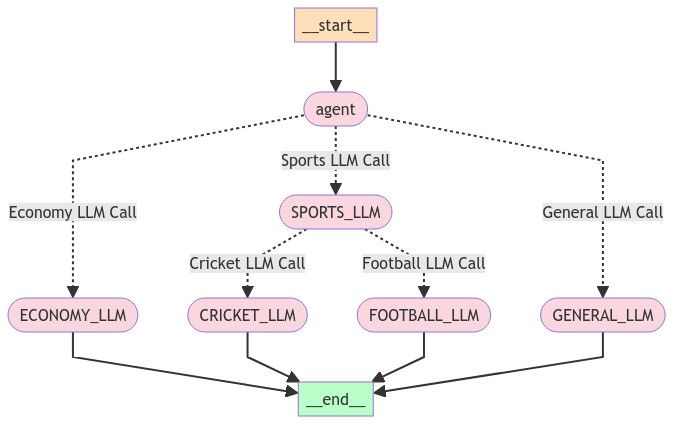

In [12]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

### Sample Questions

#### Sports Related Question

In [13]:
inputs = {"messages": ["Who won the ICC Cricket World Cup on 2011?"]}
out = app.invoke(inputs)

-> Calling Agent ->
Topic='Sports'
-> Router ->
Sports
-> Calling Sports LLM ->
-> Sports Router ->
cricket
-> Calling Sports LLM (Cricket) ->


In [14]:
out['messages']

['Who won the ICC Cricket World Cup on 2011?',
 'Sports',
 'cricket',
 'India won the ICC Cricket World Cup in 2011.']

In [15]:
inputs = {"messages": ["Who won the Football World Cup on 2018?"]}
out = app.invoke(inputs)

-> Calling Agent ->
Topic='Sports'
-> Router ->
Sports
-> Calling Sports LLM ->
-> Sports Router ->
football
-> Calling Sports LLM (Football) ->


In [16]:
out['messages']

['Who won the Football World Cup on 2018?',
 'Sports',
 'football',
 'The French national football team won the FIFA World Cup in 2018.']

#### Ecomony Related Question

In [17]:
inputs = {"messages": ["What is the GDP Growth perchentage of India from Independence?"]}
out = app.invoke(inputs)
print(out)

-> Calling Agent ->
Topic='Economy'
-> Router ->
Economy
-> Calling Economy LLM ->
{'messages': ['What is the GDP Growth perchentage of India from Independence?', 'Economy', "As an AI language model, I can provide information up until the most recent available data, which is 2020. Since India gained independence in 1947, I can provide the GDP growth percentage for India from 1951 to 2020. However, please note that the data for the earlier years might not be as accurate as the more recent years.\n\nFrom 1951 to 2020, India's GDP growth percentage has varied significantly. The average annual GDP growth rate during this period has been around 6%. However, it is important to note that the growth rate has not been consistent throughout the years. There have been periods of high growth, as well as periods of slower growth or even negative growth.\n\nFor a more detailed analysis of India's GDP growth rate over the years, it is recommended to refer to official sources such as the Reserve Bank 

#### General Question (Not Specified)

In [18]:
inputs = {"messages": ["How many Attention Blocks are in BERT Transformer?"]}
out = app.invoke(inputs)

-> Calling Agent ->
Topic='General'
-> Router ->
General
-> Calling General LLM ->
